# Spatial domain identification 

In [1]:
import spotscope as ss
import scanpy as sc
from spotscope.utils import clustering_metrics

/nas/ljc/download/miniconda3/envs/spotscope/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# dataset_paths=[
#     "example_data/DLPFC/151507.h5ad",
#     "example_data/DLPFC/151508.h5ad",
#     "example_data/DLPFC/151509.h5ad",
#     "example_data/DLPFC/151669.h5ad",
#     "example_data/DLPFC/151670.h5ad",
#     "example_data/DLPFC/151671.h5ad",
#     "example_data/DLPFC/151673.h5ad",
#     "example_data/DLPFC/151674.h5ad",
#     "example_data/DLPFC/151675.h5ad",
# ]

In [3]:
# Pretraining stage, if have pretrained, please comment this part.

# ss.train(
#     exp_name='ckpt/test.pt',
#     max_epochs=150,
#     model=ss.CLIPModel(
#         temperature=0.01,
#         image_embedding=1024,
#         spot_embedding=7,
#         projection_dim=128
#     ),
#     dataset_paths=[
#       "example_data/DLPFC/151507.h5ad",
#       "example_data/DLPFC/151508.h5ad",
#       "example_data/DLPFC/151509.h5ad",
#       "example_data/DLPFC/151669.h5ad",
#       "example_data/DLPFC/151670.h5ad",
#       "example_data/DLPFC/151671.h5ad",
#       "example_data/DLPFC/151673.h5ad",
#       "example_data/DLPFC/151674.h5ad",
#       "example_data/DLPFC/151675.h5ad",
#     ],
#     batch_size=512,
#     seed=42,
#     train_ratio=0.8
# )


In [4]:
adata = sc.read_h5ad("example_data/DLPFC/151676.h5ad")

In [5]:
ss.load_model(
    adata,
    model_path="ckpt/dlpfc.pt",
    model=ss.CLIPModel(image_embedding=1024,spot_embedding=7),
)

/nas/ljc/Spotscope/spotscope/utils.py:115: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)


Finished loading model


In [6]:
ss.load_query_datasets(adata=adata)

Building query loaders
Finished building query loaders


In [7]:
ss.infer(adata=adata,  topk=50, lower_perc=0, annotation_type='discrete')

Getting image embeddings...


100%|██████████| 108/108 [00:03<00:00, 28.39it/s]


Getting spot embeddings...
Getting query coordinates...


100%|██████████| 108/108 [00:01<00:00, 82.45it/s] 


Querying...


In [8]:
celltypes = adata.uns['annotation_list']
adata.obs['pred_layer'] = celltypes[adata.obsm['inferred_spot_annotations'].argmax(1)]

In [9]:
adata

AnnData object with n_obs × n_vars = 3431 × 33538
    obs: 'layer', 'pred_layer'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'annotation_list', 'spatial', 'query_dataloaders', 'query_dataset', 'query_data_size', 'query_img_embeddings', 'reference_spot_embeddings', 'reference_annotations', 'spot_coordinates'
    obsm: 'annotations', 'spatial', 'inferred_spot_embeddings', 'inferred_spot_annotations'

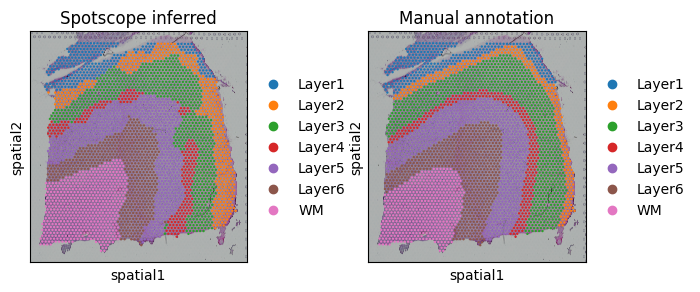

In [10]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (3, 3)

sc.pl.spatial(adata, color=['pred_layer','layer'], alpha_img=1, title=['Spotscope inferred','Manual annotation'])

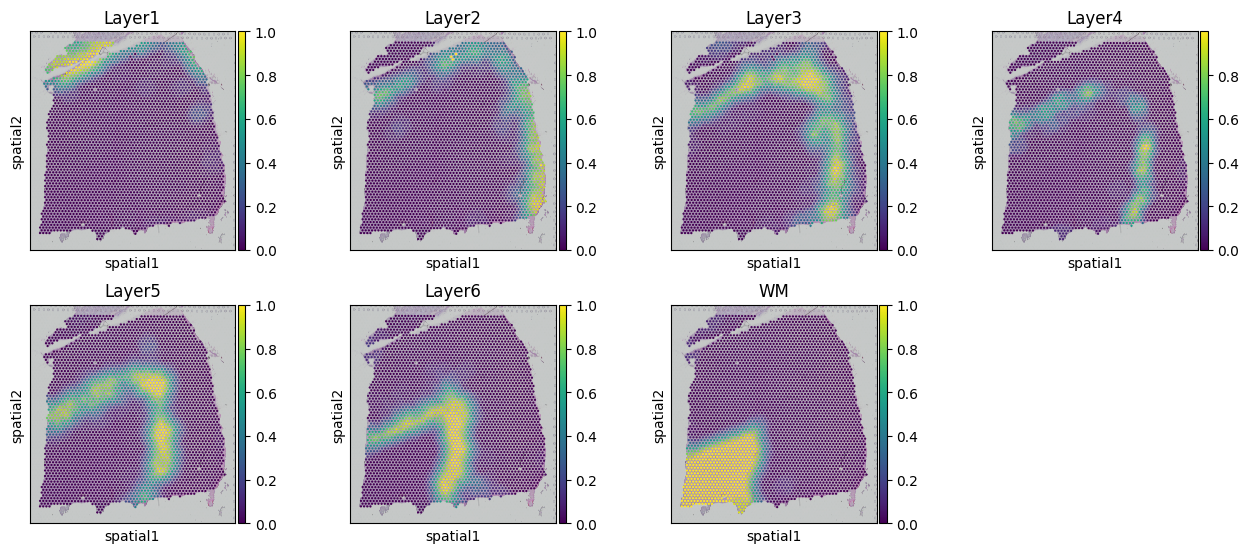

In [11]:
ss.plot_annotations(adata, annotation_reference='inferred_spot_annotations')

In [12]:
clustering_metrics(adata,predict_obs= 'pred_layer',target_obs='layer')

ARI of pred_layer is: 0.6433711959329914
NMI of pred_layer is: 0.7027413361207875


(0.6433711959329914, 0.7027413361207875)

## Super-resolution inference

In [14]:
adata_super = ss.super_infer(adata, topk=50, scale=3, distance_threshold=160, mode='advanced',annotation_type='discrete')

Building query loaders
Finished building query loaders
Getting image embeddings...


100%|██████████| 803/803 [00:22<00:00, 36.02it/s]


Getting query coordinates...


100%|██████████| 803/803 [00:09<00:00, 82.65it/s]


Querying...


In [15]:
adata_super

AnnData object with n_obs × n_vars = 25674 × 33538
    uns: 'spatial', 'query_dataloaders', 'query_dataset', 'query_data_size', 'query_img_embeddings', 'reference_spot_embeddings', 'reference_annotations', 'spot_coordinates', 'annotation_list'
    obsm: 'spatial', 'inferred_spot_embeddings', 'inferred_spot_annotations'

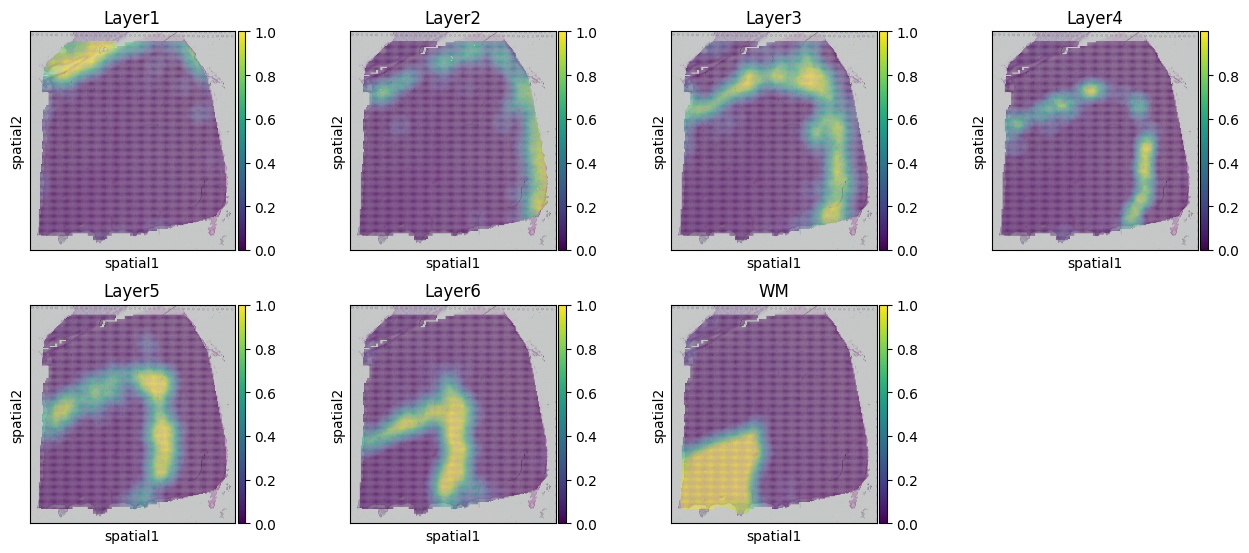

In [16]:
ss.plot_annotations(adata_super, annotation_reference='inferred_spot_annotations')

In [17]:
adata_super.obs['pred_layer'] = celltypes[adata_super.obsm['inferred_spot_annotations'].argmax(1)]

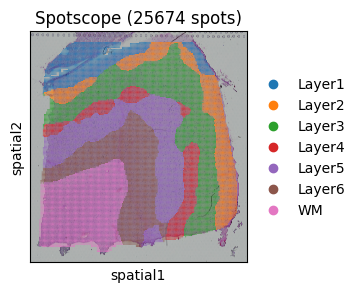

In [18]:
sc.pl.spatial(adata_super, color='pred_layer', title=f'Spotscope ({len(adata_super)} spots)',)

## UMAP and PAGA results

In [19]:
adata_paga = adata.copy()

In [20]:
# Run UMAP and PAGA with Spotscope inferred spot embeddings
import scanpy as sc
sc.pp.neighbors(adata_paga, use_rep='inferred_spot_embeddings')
sc.tl.paga(adata_paga, groups='pred_layer')
sc.tl.umap(adata_paga)

/nas/ljc/download/miniconda3/envs/spotscope/lib/python3.9/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


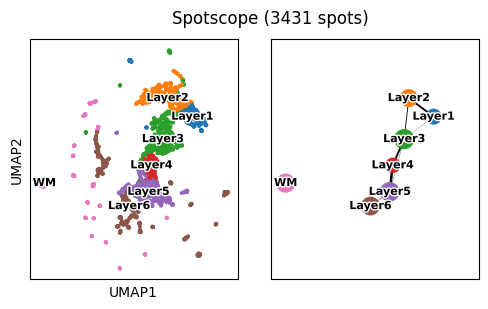

[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

In [21]:
sc.pl.paga_compare(adata_paga, legend_fontsize=8, frameon=True, size=30,
                   title=f'Spotscope ({len(adata_paga)} spots)', legend_fontoutline=2)

In [22]:
adata_super_paga = adata_super.copy()
sc.pp.neighbors(adata_super_paga, use_rep='inferred_spot_embeddings')
sc.tl.paga(adata_super_paga, groups='pred_layer')
sc.tl.umap(adata_super_paga)

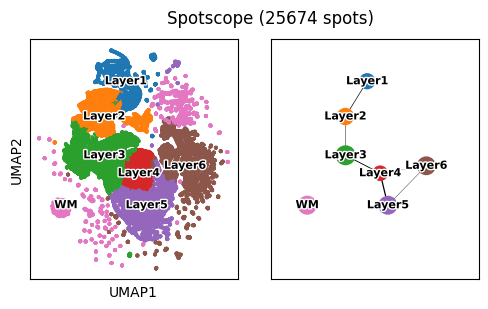

[<Axes: xlabel='UMAP1', ylabel='UMAP2'>, <Axes: >]

In [23]:
sc.pl.paga_compare(adata_super_paga, legend_fontsize=8, frameon=True, size=30,
                   title=f'Spotscope ({len(adata_super_paga)} spots)', legend_fontoutline=2)